In [1]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Conv3D, Activation, BatchNormalization, Dropout, Dense, Conv1D, Conv1DTranspose, UpSampling1D, UpSampling2D
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate, MaxPooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.applications import VGG16, MobileNetV3Small, MobileNetV2
from tensorflow.keras.losses import BinaryFocalCrossentropy, BinaryCrossentropy

print("TensorFlow Version: ", tf.__version__)


TensorFlow Version:  2.8.0


In [2]:
IMAGE_SIZE=320

# Data loading


In [2]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))
    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [3]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

In [4]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [ ]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

In [54]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

In [9]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [8]:
def double_conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same", kernel_initializer="he_normal")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [7]:
def encoder_conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same", kernel_initializer="he_normal", activation="relu")(input)
    x = Conv2D(num_filters, 3, padding="same", kernel_initializer="he_normal", activation="relu")(x)
    p = MaxPooling2D((2,2), padding="valid")(x)
    p = Dropout(0.2)(p)
    return x, p


In [6]:
def down_block(rgb, depth, num_filters):
    x = concatenate([rgb, depth])
    print(str(x))
    x = Conv2D(num_filters, 3, padding="same", kernel_initializer="he_normal", activation="relu")(x) 
    p = MaxPooling2D(2, padding="valid")(x)
    return x,p

In [5]:
def decoder_block(rgb_layer, rgb_layer_skip, depth_layer=None, depth_layer_skip=None, num_filters=16):
    rgb_layer = UpSampling2D((2, 2))(rgb_layer)
    print("X {} Xskip {} ".format(rgb_layer, rgb_layer_skip))
    x = Concatenate()([rgb_layer, rgb_layer_skip])
    x = Dropout(0.2)(x)
    x = conv_block(rgb_layer, num_filters)
    return x

In [4]:
def up_block(x, skip_x, num_filters):
    # we can put Conv2DT 
    x = UpSampling2D((2,2))(x)
    x = Concatenate()([x, skip_x])
    x = Dropout(0.2)(x)
    x = conv_block(x, num_filters)
    return x


# Custom model for 2.5D semantic segmentation

In [11]:
def build_HugoNet(image_size=320, alpha=0.35, num_classes=1):
    # 2 inputs, rgb image and depth image
    rgb = Input(shape=(image_size, image_size, 3), name='rgb')
    depth = Input(shape=(image_size, image_size, 1), name='depth')

    """ input """
    print("[*] Building model ..")

    """ Pre-trained MobileNetv2"""
    mobilenetv2 = MobileNetV2(include_top=False, weights='imagenet', input_tensor = rgb, alpha=alpha)
    # model definition 
    
    rgb1 = mobilenetv2.get_layer("rgb").output
    x1, p1 = down_block(rgb1, depth, 16)

    rgb2 = mobilenetv2.get_layer("block_1_expand_relu").output
    x2, p2 = down_block(rgb2, p1, 32)

    rgb3 = mobilenetv2.get_layer("block_3_expand_relu").output
    x3, p3 = down_block(rgb3, p2, 64)

    rgb4 = mobilenetv2.get_layer("block_6_expand_relu").output
    x4, p4 = down_block(rgb4, p3, 128)

    bottleneck_rgb = mobilenetv2.get_layer("block_13_expand_relu").output
    x  = concatenate([bottleneck_rgb, p4])
    bottleneck = double_conv_block(x, 256)
    
    u6 = up_block(bottleneck, x4, 128)

    u7 = up_block(u6, x3, 64)

    u8 = up_block(u7, x2, 32)

    u9 = up_block(u8, x1, 16)

    x = Dropout(0.1)(u9)
    # last layer for segmentation 
    x = Conv2D(num_classes, (1,1), padding="same")(x)
    x = Activation("sigmoid")(x)
    model = Model([rgb, depth], x, name="HugoNet")
    print("[*] Done")
    return model

[*] Building model ..
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-10 17:00:37.038162: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-10 17:00:37.038720: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


KerasTensor(type_spec=TensorSpec(shape=(None, 320, 320, 4), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")
KerasTensor(type_spec=TensorSpec(shape=(None, 160, 160, 64), dtype=tf.float32, name=None), name='concatenate_1/concat:0', description="created by layer 'concatenate_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 80, 80, 80), dtype=tf.float32, name=None), name='concatenate_2/concat:0', description="created by layer 'concatenate_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 40, 40, 160), dtype=tf.float32, name=None), name='concatenate_3/concat:0', description="created by layer 'concatenate_3'")
[*] Done


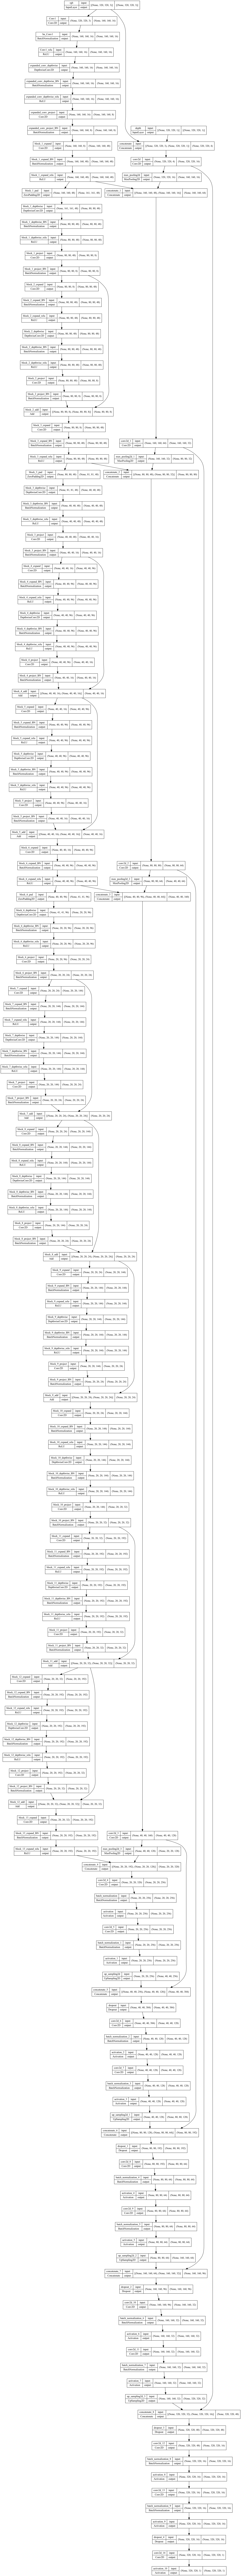

In [10]:
model = build_HugoNet()
keras.utils.plot_model(model, "multi_input_model.png", show_shapes=True)

In [ ]:
model.summary()

# Mobilenetv2 Unet - Mobile semantic segmentation neural network

In [7]:
def decoder_block(input, skip_features, num_filters, strides):
    x = Conv2DTranspose(num_filters, (2, 2), strides=strides, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [ ]:
model = MobileNetV2(include_top=False, input_tensor=Input((256, 256, 3)))
model.summary()

In [10]:
def build_mobilenetv2_unet(input_shape, alpha=0.35):
    """ input """
    print("[*] Building model ..")
    inputs = Input(input_shape, name="input_image")

    """ Pre-trained MobileNetv2"""
    mobilenetv2 = MobileNetV2(include_top=False, weights='imagenet', input_tensor = inputs, alpha=alpha)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu", "block_10_expand_relu"]

    encoder_output = mobilenetv2.get_layer('block_16_expand_relu').output
    feature_map = [16, 32, 48, 64, 80]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        print("[*] {}".format(skip_connection_names[-i]))
        x_skip = mobilenetv2.get_layer(skip_connection_names[-i]).output     

        x = UpSampling2D((2, 2))(x)
        print("X {} Xskip {} ".format(x, x_skip))

        x = Concatenate()([x, x_skip])
        
        x = Conv2D(feature_map[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(feature_map[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

    x = Dropout(0.1)(x)
    x = Dense(512, kernel_regularizer='l1')(x)
    # last layer for segmentation 
    x = Conv2D(1, (1,1), padding="same")(x)
    x = Activation("sigmoid")(x)
    model = Model(inputs, x)
    print("[*] Done")
    return model
    

In [ ]:
input_shape=(256, 256, 4)
model = build_mobilenetv2_unet(input_shape)
model.summary()

# Metrics & Training

In [64]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou(y_true,y_pred):
  def f(y_true,y_pred):
    intersection = (y_true*y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    x = (intersection + 1e-15) / (union + 1e-15)
    x = x.astype(np.float32)
    return x
  return tf.numpy_function(f,[y_true,y_pred],tf.float32)

In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)
opt = tf.keras.optimizers.Nadam(LR)
metrics = [ Recall(), Precision(), iou]

input_shape=(256, 256, 3)
model = build_mobilenetv2_unet(input_shape, alpha=0.5)
model.summary()

model.compile(loss=BinaryFocalCrossentropy(), optimizer=opt, metrics=metrics)

In [125]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [ ]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

In [84]:
model.save("unet-vanilla-0_17-0_94-0_96-0_98-0-98-val-iou-0_69")

INFO:tensorflow:Assets written to: unet-vanilla-0_17-0_94-0_96-0_98-0-98-val-iou-0_69/assets


# Evaluation

In [ ]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

model.evaluate(test_dataset, steps=test_steps)